# Processing data from Ding2018.PRA.98.042505

Spectroscopy of 87Sr triplet Rydberg states
R. Ding, J. D. Whalen, S. K. Kanungo, T. C. Killian, F. B. Dunning, S. Yoshida, and J. Burgdörfer
Phys. Rev. A 98, 042505 (2018)
https://doi.org/10.1103/PhysRevA.98.042505

In [9]:
import os
from pathlib import Path
import glob

import pandas as pd
import numpy as np
from uncertainties import ufloat, unumpy

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('talk')

## Constants
Constants to be set for each particular data set.

In [10]:
# Constants that should not need changing
C = 299792458 # Speed of light in [m/s]

# CODATA 2014 constants
RY_inf = ufloat(10973731.568508, 0.000065)/100 # Rydberg constant [/cm]
AMU = ufloat(1.660539040, 0.000000020)*1E-27 # Atomic mass unit [kg]
M_E = ufloat(9.10938356, 0.00000011)*1E-31 # Electron mass [kg]

M_88 = ufloat(87905612.256, 0.006)*1E-6*AMU
M_87 = ufloat(86908877.496, 0.005)*1E-6*AMU
M_86 = ufloat(85909260.726, 0.006)*1E-6*AMU
M_84 = ufloat(83913419.1, 1.3)*1E-6*AMU

out = pd.DataFrame(columns=['Series','n', 'Term', 'Label', 'E_exp', 'E_exp_unc', 'Isotope', 'Reference'])

In [11]:
# Constants which should change depending on the data set being analyzed
REFERENCE = 'Ding2018.PRA.98.042505'
PATH_TO_RAW_DATA = os.path.join('source','Ding2018.PRA.98.042505*.csv')
OUTPUT_FILE_NAME = REFERENCE + '-analyzed.csv'

ISOTOPE = 87

#I_S = ufloat(1377012721, 10)/(C*100/1E6) # Given ionization limit for 88Sr in paper.
I_S = ufloat(45932.1956, 0) # Given ionization limit for 87Sr in paper.

#RY_Sr = 109736.631 # Rydberg constant in [/cm]
RY_Sr = RY_inf*(M_87/(M_E + M_87))

## Read in all the files to a single DataFrame

In [44]:
# Goes through all listed .csv files and returns data in a single DataFrame

source_list = glob.glob(PATH_TO_RAW_DATA)

def gather_data(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    for file_name in file_list:
        df = pd.read_csv(file_name)
        
        out = pd.concat([out, df], join='outer', ignore_index=True, sort=False)
    
    return out

data = gather_data(source_list)
data.head()

,Series,n,Term,F,E_expt,E_expt_unc,DeltaE_Expt,DeltaE_Expt_unc,E_theor,DeltaE_theor,New
0,5sns,40,1S0,4.5,45850.8762,0.0021,16.35,0.08,45850.8702,16.22,True
1,5sns,60,1S0,4.5,45898.1444,0.0022,7.28,0.09,45898.1421,7.26,True
2,5sns,72,1S0,4.5,45909.0252,0.0020,6.10,0.09,45909.0240,6.10,True
3,5sns,74,1S0,4.5,45910.3230,0.0021,5.98,0.09,45910.3211,5.99,True
4,5sns,76,1S0,4.5,45911.5148,0.0020,5.91,0.08,45911.5127,5.89,True


## Process data
May need to tweak depending on the data set being analyzed.

### Adding in uncertainty

In [13]:
# Uncertainty is given in the paper for each measurement

### Calculating state energies after removing hyperfine shift

#### Read in Shuhei's calculated HF shifts

In [104]:
SHUHEI_HF_CALC_DIR = os.path.join(Path.cwd(), 'hyperfine_shift', '*.txt')
SHUHEI_HF_CALC_FILE = glob.glob(SHUHEI_HF_CALC_DIR)

def gather_data_txt(file_list):
    
    # Read in .csv files in to single DataFrame
    out = pd.DataFrame()
    
    for file_name in file_list:
        base_name = os.path.basename(file_name)
        
        df = pd.read_csv(file_name, sep='\s+', header=None, names=['n', 'hf_shift'])
        
        df['FILE'] = base_name
        
        ######## 5sns, 1S0 ########
        # 5sns, 1S0, F=9/2
        if base_name == 'I_1S0.txt':
            df['Series'] = '5sns'
            df['Term'] = '1S0'
            df['F'] = 9/2
        
        ######## 5sns, 3S1 ########
        # 5sns, 3S1, F=11/2
        elif base_name == 'I+1_3S1.txt':
            df['Series'] = '5sns'
            df['Term'] = '3S1'
            df['F'] = 11/2
        
        # 5sns, 3S1, F=9/2
        elif base_name == 'I_3S1.txt':
            df['Series'] = '5sns'
            df['Term'] = '3S1'
            df['F'] = 9/2
        
        # 5sns, 3S1, F=7/2
        elif base_name == 'I-1_3S1.txt':
            df['Series'] = '5sns'
            df['Term'] = '3S1'
            df['F'] = 7/2
        
        ######## 5snd, 1D2 ########
        # 5snd, 1D2, F=13/2
        elif base_name == 'I+2_1D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '1D2'
            df['F'] = 13/2
        
        # 5snd, 1D2, F=11/2
        elif base_name == 'I+1_1D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '1D2'
            df['F'] = 11/2
        
        # 5snd, 1D2, F=9/2
        elif base_name == 'I_1D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '1D2'
            df['F'] = 9/2
        
        # 5snd, 1D2, F=7/2
        elif base_name == 'I-1_1D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '1D2'
            df['F'] = 7/2
        
        # 5snd, 1D2, F=5/2
        elif base_name == 'I-2_1D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '1D2'
            df['F'] = 5/2
        
        ######## 5snd, 3D1 ########
        # 5snd, 3D1, F=11/2
        elif base_name == 'I+1_3D1.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D1'
            df['F'] = 11/2
        
        # 5snd, 3D1, F=9/2
        elif base_name == 'I_3D1.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D1'
            df['F'] = 9/2
        
        # 5snd, 3D1, F=7/2
        elif base_name == 'I-1_3D1.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D1'
            df['F'] = 7/2
        
        ######## 5snd, 3D2 ########
        # 5snd, 3D2, F=13/2
        elif base_name == 'I+2_3D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D2'
            df['F'] = 13/2
        
        # 5snd, 3D2, F=11/2
        elif base_name == 'I+1_3D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D2'
            df['F'] = 11/2
        
        # 5snd, 3D2, F=9/2
        elif base_name == 'I_3D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D2'
            df['F'] = 9/2
        
        # 5snd, 3D2, F=7/2
        elif base_name == 'I-1_3D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D2'
            df['F'] = 7/2
        
        # 5snd, 3D2, F=5/2
        elif base_name == 'I-2_3D2.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D2'
            df['F'] = 5/2
        
        ######## 5snd, 3D3 ########
        # 5snd, 3D3, F=15/2
        elif base_name == 'I+3_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 15/2
        
        # 5snd, 3D3, F=13/2
        elif base_name == 'I+2_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 13/2
        
        # 5snd, 3D3, F=11/2
        elif base_name == 'I+1_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 11/2
        
        # 5snd, 3D3, F=9/2
        elif base_name == 'I_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 9/2
        
        # 5snd, 3D3, F=7/2
        elif base_name == 'I-1_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 7/2
        
        # 5snd, 3D3, F=5/2
        elif base_name == 'I-2_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 5/2
        
        # 5snd, 3D3, F=3/2
        elif base_name == 'I-3_3D3.txt':
            df['Series'] = '5snd'
            df['Term'] = '3D3'
            df['F'] = 3/2
        
        out = pd.concat([out, df], join='outer', ignore_index=True, sort=False)
    
    return out

shuhei_hf_calc = gather_data_txt(SHUHEI_HF_CALC_FILE)

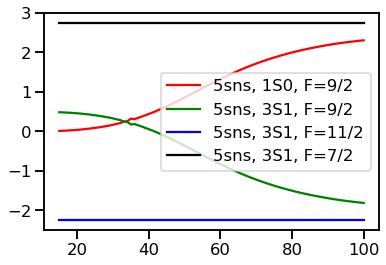

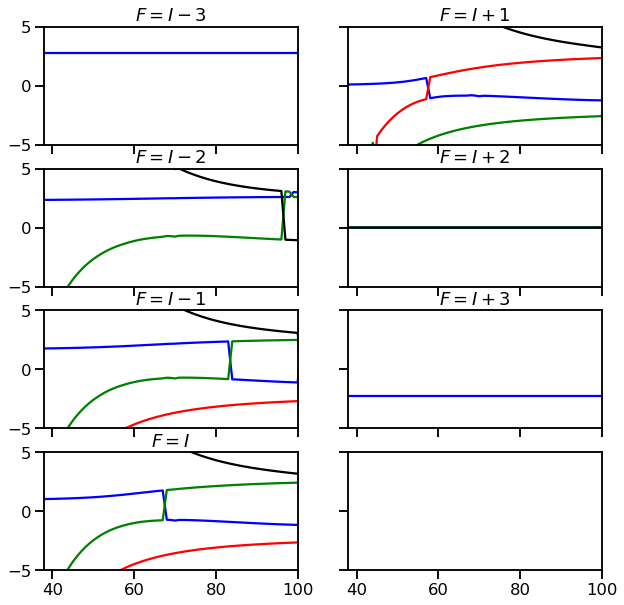

In [123]:
# Checking if I read Shuhei's calculations in correctly

######## S-state data ########
plt.figure()
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='1S0')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='1S0')
                   & (shuhei_hf_calc['F']==9/2)]['hf_shift']
plt.plot(n, dE, label=r'5sns, 1S0, F=9/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==9/2)]['hf_shift']
plt.plot(n, dE, label=r'5sns, 3S1, F=9/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==11/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==11/2)]['hf_shift']
plt.plot(n, dE, label=r'5sns, 3S1, F=11/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==7/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5sns')
                   & (shuhei_hf_calc['Term']=='3S1')
                   & (shuhei_hf_calc['F']==7/2)]['hf_shift']
plt.plot(n, dE, label=r'5sns, 3S1, F=7/2', color='black')
plt.legend()
plt.show()

######## D-state data ########
# D-states, F=I-3
[fig, axs] = plt.subplots(ncols=2, nrows=4, figsize=(10,10), sharex=True, sharey=True)
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2-3)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2-3)]['hf_shift']
axs[0,0].plot(n, dE, label=r'5snd, 3D3, F=3/2', color='blue')
axs[0,0].set_title(r'$F=I-3$')

# D-states, F=I-2
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2-2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2-2)]['hf_shift']
axs[1,0].plot(n, dE, label=r'5snd, 3D3, F=5/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D2')
                   & (shuhei_hf_calc['F']==9/2-2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D2')
                    & (shuhei_hf_calc['F']==9/2-2)]['hf_shift']
axs[1,0].plot(n, dE, label=r'5snd, 3D2, F=5/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D1')
                   & (shuhei_hf_calc['F']==9/2-2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D1')
                    & (shuhei_hf_calc['F']==9/2-2)]['hf_shift']
axs[1,0].plot(n, dE, label=r'5snd, 3D1, F=5/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='1D2')
                   & (shuhei_hf_calc['F']==9/2-2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='1D2')
                    & (shuhei_hf_calc['F']==9/2-2)]['hf_shift']
axs[1,0].plot(n, dE, label=r'5snd, 1D2, F=5/2', color='black')
axs[1,0].set_title(r'$F=I-2$')

# D-states, F=I-1
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2-1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2-1)]['hf_shift']
axs[2,0].plot(n, dE, label=r'5snd, 3D3, F=7/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D2')
                   & (shuhei_hf_calc['F']==9/2-1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D2')
                    & (shuhei_hf_calc['F']==9/2-1)]['hf_shift']
axs[2,0].plot(n, dE, label=r'5snd, 3D2, F=7/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D1')
                   & (shuhei_hf_calc['F']==9/2-1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D1')
                    & (shuhei_hf_calc['F']==9/2-1)]['hf_shift']
axs[2,0].plot(n, dE, label=r'5snd, 3D1, F=7/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='1D2')
                   & (shuhei_hf_calc['F']==9/2-1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='1D2')
                    & (shuhei_hf_calc['F']==9/2-1)]['hf_shift']
axs[2,0].plot(n, dE, label=r'5snd, 1D2, F=7/2', color='black')
axs[2,0].set_title(r'$F=I-1$')

# D-states, F=I
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2)]['hf_shift']
axs[3,0].plot(n, dE, label=r'5snd, 3D3, F=9/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D2')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D2')
                    & (shuhei_hf_calc['F']==9/2)]['hf_shift']
axs[3,0].plot(n, dE, label=r'5snd, 3D2, F=9/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D1')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D1')
                    & (shuhei_hf_calc['F']==9/2)]['hf_shift']
axs[3,0].plot(n, dE, label=r'5snd, 3D1, F=9/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='1D2')
                   & (shuhei_hf_calc['F']==9/2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='1D2')
                    & (shuhei_hf_calc['F']==9/2)]['hf_shift']
axs[3,0].plot(n, dE, label=r'5snd, 1D2, F=9/2', color='black')
axs[3,0].set_title(r'$F=I$')

# D-states, F=I+1
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2+1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2+1)]['hf_shift']
axs[0,1].plot(n, dE, label=r'5snd, 3D3, F=11/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D2')
                   & (shuhei_hf_calc['F']==9/2+1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D2')
                    & (shuhei_hf_calc['F']==9/2+1)]['hf_shift']
axs[0,1].plot(n, dE, label=r'5snd, 3D2, F=11/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D1')
                   & (shuhei_hf_calc['F']==9/2+1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D1')
                    & (shuhei_hf_calc['F']==9/2+1)]['hf_shift']
axs[0,1].plot(n, dE, label=r'5snd, 3D1, F=11/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='1D2')
                   & (shuhei_hf_calc['F']==9/2+1)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='1D2')
                    & (shuhei_hf_calc['F']==9/2+1)]['hf_shift']
axs[0,1].plot(n, dE, label=r'5snd, 1D2, F=11/2', color='black')
axs[0,1].set_title(r'$F=I+1$')

# D-states, F=I+2
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2+2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2+2)]['hf_shift']
axs[1,1].plot(n, dE, label=r'5snd, 3D3, F=13/2', color='blue')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D2')
                   & (shuhei_hf_calc['F']==9/2+2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D2')
                    & (shuhei_hf_calc['F']==9/2+2)]['hf_shift']
axs[1,1].plot(n, dE, label=r'5snd, 3D2, F=13/2', color='green')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D1')
                   & (shuhei_hf_calc['F']==9/2+2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D1')
                    & (shuhei_hf_calc['F']==9/2+2)]['hf_shift']
axs[1,1].plot(n, dE, label=r'5snd, 3D1, F=13/2', color='red')

n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='1D2')
                   & (shuhei_hf_calc['F']==9/2+2)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='1D2')
                    & (shuhei_hf_calc['F']==9/2+2)]['hf_shift']
axs[1,1].plot(n, dE, label=r'5snd, 1D2, F=13/2', color='black')
axs[1,1].set_title(r'$F=I+2$')

# D-states, F=I+3
n = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                   & (shuhei_hf_calc['Term']=='3D3')
                   & (shuhei_hf_calc['F']==9/2+3)]['n']
dE = shuhei_hf_calc[(shuhei_hf_calc['Series']=='5snd')
                    & (shuhei_hf_calc['Term']=='3D3')
                    & (shuhei_hf_calc['F']==9/2+3)]['hf_shift']
axs[2,1].plot(n, dE, label=r'5snd, 3D3, F=15/2', color='blue')
axs[2,1].set_title(r'$F=I+3$')

plt.xlim((38, 100))
plt.ylim((-5, 5))
plt.show()

### Removing the hyperfine shift to calculate quantum defects

In [108]:
data['E_expt_noHF'] = data['E_expt']
data['E_expt_noHF_unc'] = data['E_expt_unc']

# Simple first pass
for idx, row in data.iterrows():
    
    n = row['n']
    series = row['Series']
    term = row['Term']
    F = row['F']
    
    HF_shift = shuhei_hf_calc[(shuhei_hf_calc['n'] == n)
                              & (shuhei_hf_calc['Series'] == series)
                              & (shuhei_hf_calc['Term'] == term)
                              & (shuhei_hf_calc['F'] == F)]['hf_shift']
    
    # Shuhei didn't give uncertainties in his calculations.
    HF_shift = ufloat(HF_shift, 0)
    
    # Convert from [GHz] to [/cm]
    HF_shift = HF_shift/C*1E9/1E2
    
    data.at[idx, 'E_expt_noHF'] = row['E_expt_noHF'] - HF_shift.nominal_value
    data.at[idx, 'E_expt_noHF_unc'] = row['E_expt_noHF_unc'] - HF_shift.std_dev

### Doing any additional filtering (e.g., excluding some ranges, etc.)

In [109]:
# Only keep data that's newly presented (some data tables include previously measured data)
data_working = data[data['New'] & ~pd.isna(data['New'])]

### Put data in to a standardized table

In [110]:
# Only keep data that's newly presented (some data tables include previously measured data)
out['Term'] = data_working['Term']
out['n'] = data_working['n']
out['E_exp'] = data_working['E_expt_noHF']
out['E_exp_unc'] = data_working['E_expt_noHF_unc']

# Set the isotope
out['Isotope'] = ISOTOPE
out['Reference'] = REFERENCE

# Specify the series based on the term
#for idx, row in out.iterrows():
#    if row['Term'] == '3S1':
#        out.at[idx, 'Series'] = '5sns'
#    elif row['Term'] == '1D2' or row['Term'] == '3D1' or row['Term'] == '3D2' or row['Term'] == '3D3':
#        out.at[idx, 'Series'] = '5snd'
#    else:
#        print('Error with assigning series')
out['Series'] = data_working['Series']

# Label the states
for idx, row in out.iterrows():
    out.at[idx, 'Label'] = row['Series'].replace('n', str(row['n']))

### Calculate quantum defect

In [111]:
n = out['n']
E_exp = unumpy.uarray(out['E_exp'], out['E_exp_unc'])
delta_expt = n - unumpy.sqrt(RY_Sr/(I_S-E_exp))

out['delta_exp'] = unumpy.nominal_values(delta_expt)
out['delta_exp_unc'] = unumpy.std_devs(delta_expt)

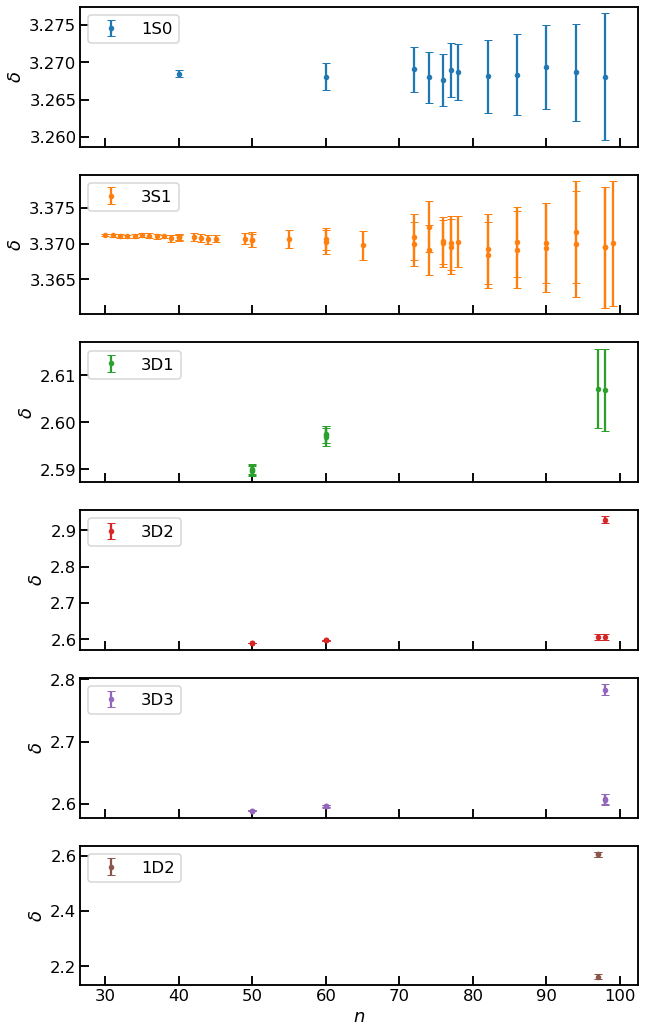

In [112]:
plt_kwargs = {'capsize':4,
              'fmt':'.'}

nrows = len(out['Term'].unique())

if nrows > 1:
    [fig, axs] = plt.subplots(nrows=nrows, ncols=1, figsize=(10,3*nrows), sharex=True, sharey=False)

    for i, T in enumerate(out['Term'].unique()):
        x = out[out['Term'] == T]['n']
        y = out[out['Term'] == T]['delta_exp']
        yerr = out[out['Term'] == T]['delta_exp_unc']
        axs[i].errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[i])
        axs[i].legend()
        axs[i].tick_params(axis='both', direction='in')
        axs[i].set_ylabel(r'$\delta$')

    plt.xlabel(r'$n$')
    plt.show()

else:
    plt.figure(figsize=(10,3))
    
    T = out['Term'].unique()[0]
    
    x = out['n']
    y = out['delta_exp']
    yerr = out['delta_exp_unc']
    plt.errorbar(x, y, yerr=yerr, label=T, **plt_kwargs, color=sns.color_palette()[0])
    plt.legend()
    plt.gca().tick_params(axis='both', direction='in')

    plt.xlabel(r'$n$')
    plt.ylabel(r'$\delta$')
    plt.show()

### Write out processed data as .csv

In [113]:
out.to_csv(OUTPUT_FILE_NAME, index=False)